{0: 5421, 1: 5, 2: 5421, 3: 5421, 4: 5421, 5: 5421, 6: 5421, 7: 5421, 8: 5421, 9: 5421}


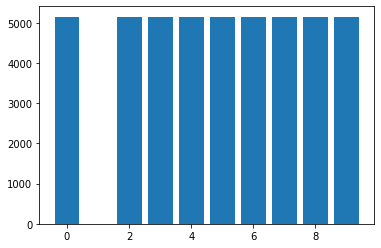

mu = 0.1, rho = 1287.5


RuntimeError: /job:localhost/replica:0/task:0/device:GPU:0 unknown device.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import Helper_functions as hf
import json
import copy
import imblearn
import sklearn
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
def model_run(model_name, epochs, ti, tl, vi, vl, optimizer, loss, metrics, callbacks, initial_epoch = 0):
    model_name.add(tf.keras.layers.Conv2D(28, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.Flatten())
    model_name.add(tf.keras.layers.Dense(56, activation = 'relu'))
    model_name.add(tf.keras.layers.Dense(10))
    model_name.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    with tf.device('GPU:0'):
        history = model_name.fit(
        ti, tl,
        epochs = epochs,
        initial_epoch = initial_epoch,
        validation_data = (vi, vl))
        model_name.summary()
    return history
with tf.device('CPU:0'):
    (imb_train_images, imb_train_labels) = hf.Imbalance.change_set_statistics(train_images, 
                                                                              train_labels, np.float32(0.1), 1000)
    print(hf.Imbalance.get_set_distribution(imb_train_labels))
    sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.05)
    sss.get_n_splits(imb_train_images, imb_train_labels)
    (imb_train_indices, imb_validation_indices) = next(sss.split(imb_train_images, imb_train_labels))
    (imb_validation_images, imb_validation_labels) = (imb_train_images[imb_validation_indices], imb_train_labels[imb_validation_indices])
    (imb_train_images, imb_train_labels) = (imb_train_images[imb_train_indices], imb_train_labels[imb_train_indices])    
    hf.Imbalance.plot_set_distribution(imb_train_images, imb_train_labels)
    test_images_expanded = np.expand_dims(test_images, axis = 3)
    imb_train_images_expanded = np.expand_dims(imb_train_images, axis = 3)
    imb_validation_images_expanded = np.expand_dims(imb_validation_images, axis = 3)
    imb_train_images_tf = tf.cast(imb_train_images_expanded, dtype = tf.float32) / 255.0
    imb_validation_images_tf = tf.cast(imb_validation_images_expanded, dtype = tf.float32) / 255.0
    test_images_tf = tf.cast(test_images_expanded, dtype = tf.float32) / 255.0
    gmeans = list()
    fscores = list()
for epsilon in np.linspace(0.01, 0.5, 20):
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    metrics = ['acc']
    callbacks = list()
    model_aos = tf.keras.models.Sequential()
    history = model_run(model_aos, 10, imb_train_images_tf, imb_train_labels, 
                        imb_validation_images_tf, imb_validation_labels, 
                        optimizer, loss, metrics, callbacks)
    distribution = hf.Imbalance.get_set_distribution(imb_train_labels)
    aos_train_images, aos_train_labels = hf.Adversarial.oversample(imb_train_images_expanded, imb_train_labels,
                                                   tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                                                   model_aos, [epsilon], 
                                                   data_type = 'step')
    with tf.device('CPU:0'):
        aos_train_images = np.true_divide(aos_train_images, 255.0)
        aos_train_images_tf = tf.cast(aos_train_images, dtype = tf.float32)
    aos_history = model_aos.fit(aos_train_images_tf, aos_train_labels, epochs = 5, 
                                validation_data = (imb_validation_images_tf, imb_validation_labels))
    plt.title('losses')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.plot(history.history['loss'], label = 'loss')
    plt.legend(loc = 'best')
    plt.show()
    plt.title('accuracies')
    plt.plot(history.history['val_acc'], label = 'val_acc')
    plt.plot(history.history['acc'], label = 'acc')
    plt.legend(loc = 'best')
    plt.show()
    print('aos')
    plt.title('losses')
    plt.plot(aos_history.history['val_loss'], label = 'val_loss')
    plt.plot(aos_history.history['loss'], label = 'loss')
    plt.legend(loc = 'best')
    plt.show()
    plt.title('accuracies')
    plt.plot(aos_history.history['val_acc'], label = 'val_acc')
    plt.plot(aos_history.history['acc'], label = 'acc')
    plt.legend(loc = 'best')
    plt.show()
    with tf.device('CPU:0'):
        model_aos_test_preds = tf.argmax(model_aos(test_images_tf), axis=-1)
        model_aos_gmean = imblearn.metrics.geometric_mean_score(test_labels, model_aos_test_preds, 
                                                               correction = np.finfo(np.float32).eps)
        model_aos_fscore = sklearn.metrics.f1_score(test_labels, model_aos_test_preds, average = 'macro')
    print(f'gmean: {model_aos_gmean} \nfscore: {model_aos_fscore}')
    gmeans.append(model_aos_gmean)
    fscores.append(model_aos_fscore)